# Parse the results of the experiment

In [1]:
import os

root_path = '/Users/lixin/Workplace/box'
result_path = os.path.join(root_path, 'data')
param_json_path = os.path.join(root_path, 'json/numberOfParamPerOp.json')

In [2]:
import json

param_num_per_op = dict()
data = json.load(open(param_json_path, 'r'))
for sut, op_list in data.items():
    for op, w in op_list.items():
        param_num_per_op[(sut, op)] = w

In [3]:
import json
import os
import pandas as pd

op_bug_dfs = []
bug_info = pd.DataFrame(columns=['sut', 'tool', 'round', 'bug_id'])
# read all projects
for folder in os.listdir(result_path):
    folder_path = os.path.join(result_path, folder)
    if not os.path.isdir(folder_path):
        continue
    tool_name = "_".join(folder.split('_')[:-1])
    for i in range(1, 11):
        round_path = os.path.join(folder_path, f'round{i}')
        if os.path.exists(round_path):
            df = pd.read_csv(os.path.join(round_path, "coverage_and_bug.csv"))
            df['tool'] = tool_name
            op_bug_dfs.append(df)

            for file in os.listdir(round_path):
                if file.endswith('_bug.json'):
                    sut = file.split('_')[0]
                    with open(os.path.join(round_path, file), 'r') as f:
                        bug_json = json.load(f)
                        for op, bugs in bug_json.items():
                            for bug in bugs:
                                bug_info = pd.concat([bug_info, pd.DataFrame([{'sut': sut, 'tool': tool_name, 'round': i, 'bug_id': f"{op}:{bug}"}])], ignore_index=True)
total_df = pd.concat(op_bug_dfs)
total_df["coverage"] = total_df['Op_20X_50X'] / total_df['Op_All']
total_df['coverage'] = total_df['coverage'].round(2)
total_df

,SUT,Op_20X,Op_20X_50X,Op_All,Duration,Total Bugs,Unique Bugs,tool,coverage
0,emb-project,5.0,19.0,60.0,3595.0,37553.0,15.0,evomaster,0.32
1,features-service,12.0,18.0,18.0,3599.0,117701.0,13.0,evomaster,1.00
2,genome-nexus,16.0,17.0,23.0,3594.0,68.0,1.0,evomaster,0.74
3,languagetool,1.0,2.0,2.0,3596.0,8023.0,5.0,evomaster,1.00
4,market,1.0,4.0,13.0,3595.0,38862.0,3.0,evomaster,0.31
...,...,...,...,...,...,...,...,...,...
5,ncs,6.0,6.0,6.0,3599.0,0.0,0.0,emrest,1.00
6,person-controller,8.0,12.0,12.0,3597.0,14971.0,168.0,emrest,1.00
7,restcountries,22.0,22.0,22.0,3599.0,503.0,1.0,emrest,1.00
8,scs,11.0,11.0,11.0,3599.0,0.0,0.0,emrest,1.00


In [4]:
# each row of total_df is the average of ten runs for a specific sut, tool
# the number of rows should be 5 approaches * 16 suts * 10 runs = 800
total_df.tool.unique()

array(['evomaster', 'arat-rl', 'miner', 'emrest', 'emrest_infer'],
      dtype=object)

In [5]:
from tqdm import tqdm
import numpy as np


def count(_df):
    def count_before_first_20X(group):
        # sort by timestamp and reset index
        group_df = group.sort_values('timestamp').reset_index(drop=True)
        # 找到首次出现20X的索引
        first_20X_50X_idx = group_df[group_df['status_group'].isin(['20X', '50X'])].index.min()

        if pd.isna(first_20X_50X_idx):
            # 如果没有找到20X，返回NaN
            return np.nan
        else:
            # 计算首次20X之前的数量
            return first_20X_50X_idx - group_df.index.min() + 1

    # 按 sut 和 op 分组
    grouped = _df.groupby(['sut', 'op'])
    # 应用函数到每个组
    return grouped.apply(count_before_first_20X, include_groups=False).reset_index(drop=False)


request_info_dfs = []

for folder in tqdm(os.listdir(result_path)):
    if not os.path.isdir(os.path.join(result_path, folder)):
        continue
    tool_name = "_".join(folder.split('_')[:-1])
    for i in range(1, 11):
        round_path = os.path.join(result_path, folder, f'round{i}')
        if os.path.exists(round_path):
            request_info = os.path.join(round_path, "request_info.csv")
            df = pd.read_csv(request_info)
            df = count(df)
            df.columns = ['sut', 'op', 'first_20X_50X']
            df['tool'] = tool_name
            df['round'] = i
            request_info_dfs.append(df)

total_request_info = pd.concat(request_info_dfs, ignore_index=True)
# Nan: no 20X response and 50X response
total_request_info = total_request_info.dropna(subset=['first_20X_50X'])
total_request_info

100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


,sut,op,first_20X_50X,tool,round
10,emb-project,delete:/app/api/locations,470.0,evomaster,1
11,emb-project,delete:/app/api/locations/delete,1129.0,evomaster,1
12,emb-project,delete:/app/api/projects,134.0,evomaster,1
13,emb-project,delete:/app/api/projects/delete,22.0,evomaster,1
15,emb-project,get:/app/api/assignments/data/project-commit/{...,1.0,evomaster,1
...,...,...,...,...,...
13646,user-management,post:/users/rbac/roles/{roleId}/permissions/{p...,2.0,emrest,10
13647,user-management,post:/users/register,10.0,emrest,10
13648,user-management,post:/users/{id}/roles/{roleId},1.0,emrest,10
13649,user-management,put:/error,1.0,emrest,10


In [6]:
# the order of sut to be displayed 
order = {"features-service": 0,
         "feature-services": 0,
         "genome-nexus": 1,
         "languagetool": 2,
         "market": 3,
         "person-controller": 4,
         "emb-project": 5,
         "restcountries": 6,
         "user-management": 7,
         "ncs": 8,
         "scs": 9,
         "gitlab-branch": 10,
         "gitlab-commit": 11,
         "gitlab-groups": 12,
         "gitlab-issues": 13,
         "gitlab-project": 14,
         "gitlab-repository": 15
         }


# RQ1: Operation Coverages

In [7]:
# for each sut on each tool, the average operation coverage (Op_20X: operations with 200-range HTTP responses, Op_20X_50X: operations with 200-range HTTP responses or 500-range HTTP responses) and 
# the average number of unique bugs (unique bugs detected in ten runs)
# the duration is the average duration of ten runs, and each duration should be close to 3600s, and the count is the number of runs
summarized = total_df.groupby(['SUT', 'tool']).agg(op_20x=('Op_20X', 'mean'), op_20x_50x=('Op_20X_50X', 'mean'), coverage=('coverage', 'mean') , total_bugs=('Total Bugs', 'mean'), unique_bugs=
('Unique Bugs', 
                                                                                                                                                                                 'mean'), count=
('Duration', 'size')).reset_index()

In [8]:
op_coverage = summarized.pivot(index='SUT', columns='tool', values=['coverage'])
op_coverage.sort_values(by=['SUT'], key=lambda x: x.map(order), inplace=True)
# to latex, 保留两位小数
op_coverage = op_coverage.round(2)
op_coverage

coverage                                    
tool               arat-rl emrest emrest_infer evomaster miner
SUT                                                           
features-service      1.00   1.00         1.00      1.00  0.94
genome-nexus          1.00   0.99         0.91      0.72  0.41
languagetool          1.00   1.00         1.00      1.00  0.50
market                0.62   0.62         0.31      0.31  0.34
person-controller     1.00   1.00         1.00      1.00  1.00
emb-project           0.77   0.82         0.80      0.32  0.28
restcountries         0.99   1.00         1.00      0.76  0.09
user-management       0.93   1.00         0.91      0.82  0.49
ncs                   1.00   1.00         1.00      1.00  0.83
scs                   1.00   1.00         1.00      1.00  0.99
gitlab-branch         0.82   1.00         0.99      0.56  0.11
gitlab-commit         0.20   0.33         0.31      0.22  0.07
gitlab-groups         0.57   0.58         0.60      0.59  0.06
gitlab-issues         0.83   0.91         0.90      0.32  0.07
gitlab-project        0.64   0.83         0.82      0.51  0.10
gitlab-repository     0.34   0.41         0.33      0.48  0.10

# RQ1: Test Inputs Needed to Trigger the First 200-range or 500-range HTTP Response

In [9]:
# group by sut, op, tool，filter out groups with less than 10 records
filtered_out_not_ten_runs = total_request_info.groupby(['sut', 'op', 'tool']).filter(lambda x: len(x) == 10)
filtered_out_not_ten_runs

,sut,op,first_20X_50X,tool,round
10,emb-project,delete:/app/api/locations,470.0,evomaster,1
11,emb-project,delete:/app/api/locations/delete,1129.0,evomaster,1
12,emb-project,delete:/app/api/projects,134.0,evomaster,1
13,emb-project,delete:/app/api/projects/delete,22.0,evomaster,1
15,emb-project,get:/app/api/assignments/data/project-commit/{...,1.0,evomaster,1
...,...,...,...,...,...
13646,user-management,post:/users/rbac/roles/{roleId}/permissions/{p...,2.0,emrest,10
13647,user-management,post:/users/register,10.0,emrest,10
13648,user-management,post:/users/{id}/roles/{roleId},1.0,emrest,10
13649,user-management,put:/error,1.0,emrest,10


In [10]:
# group by tool, sut, op，calculate the mean and std of first_20X_50X
avg_first_20x_50x = filtered_out_not_ten_runs.groupby(['tool', 'sut'])['first_20X_50X'].mean().reset_index().pivot(index='sut', columns='tool', values=['first_20X_50X']).sort_values(by=['sut'],
                                                                                                                                                                                      key=lambda x: x
                                                                                                                                                                                      .map(order))
avg_first_20x_50x

first_20X_50X                                               
tool                    arat-rl      emrest emrest_infer   evomaster     miner
sut                                                                           
features-service       1.416667    1.038889     1.055556    1.000000  1.000000
genome-nexus          12.626087    6.595455     1.410000   19.906250  1.000000
languagetool          46.500000    4.050000     4.950000    3.100000  1.000000
market                11.200000   10.762500     1.000000    1.875000  1.000000
person-controller      1.000000    1.000000     1.000000    1.000000  1.000000
emb-project          110.131707  113.513043    95.520000  229.378947  1.071429
restcountries        240.233333    2.709091     2.813636  794.693333  1.000000
user-management       58.389474   24.250000    19.970000  150.752941  1.000000
ncs                   24.150000    3.033333     2.200000    1.066667  1.000000
scs                    1.072727    1.354545     1.245455    1.000000  1.000000
gitlab-branch        210.783333  109.466667    26.525000  630.360000  1.200000
gitlab-commit        524.466667  218.400000   208.175000  811.833333  1.200000
gitlab-groups        650.033333   38.022222    45.755556  246.730000  1.100000
gitlab-issues        128.345000   44.379167    33.808333  510.671429  1.100000
gitlab-project        20.700000   96.080000    47.068000  486.025000  2.533333
gitlab-repository    146.233333  146.066667   126.166667  554.900000  1.200000

In [11]:
# concat op_coverage and avg_first_20x_50x
pd.concat([op_coverage, avg_first_20x_50x], axis=1)

coverage                                     first_20X_50X  \
tool               arat-rl emrest emrest_infer evomaster miner       arat-rl   
features-service      1.00   1.00         1.00      1.00  0.94      1.416667   
genome-nexus          1.00   0.99         0.91      0.72  0.41     12.626087   
languagetool          1.00   1.00         1.00      1.00  0.50     46.500000   
market                0.62   0.62         0.31      0.31  0.34     11.200000   
person-controller     1.00   1.00         1.00      1.00  1.00      1.000000   
emb-project           0.77   0.82         0.80      0.32  0.28    110.131707   
restcountries         0.99   1.00         1.00      0.76  0.09    240.233333   
user-management       0.93   1.00         0.91      0.82  0.49     58.389474   
ncs                   1.00   1.00         1.00      1.00  0.83     24.150000   
scs                   1.00   1.00         1.00      1.00  0.99      1.072727   
gitlab-branch         0.82   1.00         0.99      0.56  0.11    210.783333   
gitlab-commit         0.20   0.33         0.31      0.22  0.07    524.466667   
gitlab-groups         0.57   0.58         0.60      0.59  0.06    650.033333   
gitlab-issues         0.83   0.91         0.90      0.32  0.07    128.345000   
gitlab-project        0.64   0.83         0.82      0.51  0.10     20.700000   
gitlab-repository     0.34   0.41         0.33      0.48  0.10    146.233333   

                                                                  
tool                   emrest emrest_infer   evomaster     miner  
features-service     1.038889     1.055556    1.000000  1.000000  
genome-nexus         6.595455     1.410000   19.906250  1.000000  
languagetool         4.050000     4.950000    3.100000  1.000000  
market              10.762500     1.000000    1.875000  1.000000  
person-controller    1.000000     1.000000    1.000000  1.000000  
emb-project        113.513043    95.520000  229.378947  1.071429  
restcountries        2.709091     2.813636  794.693333  1.000000  
user-management     24.250000    19.970000  150.752941  1.000000  
ncs                  3.033333     2.200000    1.066667  1.000000  
scs                  1.354545     1.245455    1.000000  1.000000  
gitlab-branch      109.466667    26.525000  630.360000  1.200000  
gitlab-commit      218.400000   208.175000  811.833333  1.200000  
gitlab-groups       38.022222    45.755556  246.730000  1.100000  
gitlab-issues       44.379167    33.808333  510.671429  1.100000  
gitlab-project      96.080000    47.068000  486.025000  2.533333  
gitlab-repository  146.066667   126.166667  554.900000  1.200000

# RQ1: Test Inputs Needed to Trigger the First 200-range or 500-range HTTP Response - Figure

In [12]:
sut = 'emb-project'
sut_df = filtered_out_not_ten_runs[filtered_out_not_ten_runs.sut == sut].groupby(['op', 'tool'])['first_20X_50X'].mean().reset_index()

# remove tool 'emrest_infer'
sut_df = sut_df[sut_df.tool != 'emrest_infer']
sut_df['num_params'] = sut_df.apply(lambda x: param_num_per_op[(sut, x['op'])], axis=1)

op_order = []
tool = ['miner', 'evomaster', 'arat-rl', 'emrest']
for t in tool:
    last_idx = len(op_order)
    for idx in range(len(op_order)):
        if op_order[idx] not in sut_df[sut_df.tool == t].op.unique():
            op_order.append(op_order[idx])
            op_order.pop(idx)
    for op in sut_df[sut_df.tool == 'miner'].op.unique():
        if op not in op_order:
            op_order.append(op)
    
            
sut_df['op_weight'] = sut_df.apply(lambda x: param_num_per_op[(sut, x['op'])], axis=1)
sut_df = sut_df.sort_values(by=['op_weight'], ascending=True)
sut_df

,op,tool,first_20X_50X,num_params,op_weight
56,get:/app/api/departments,arat-rl,1.0,0,0
57,get:/app/api/departments,emrest,1.0,0,0
67,get:/app/api/employees,miner,1.0,0,0
65,get:/app/api/employees,emrest,1.0,0,0
22,get:/app/api/assignments,miner,1.0,0,0
...,...,...,...,...,...
150,put:/app/api/departments/update,arat-rl,832.4,6,6
139,put:/app/api/assignments/update,emrest,820.3,29,29
137,put:/app/api/assignments,emrest,1262.6,29,29
105,post:/app/api/assignments,emrest,1174.4,29,29


In [13]:
sut_df[sut_df.tool == 'miner'].first_20X_50X.unique()

array([1. , 1.3, 1.7])

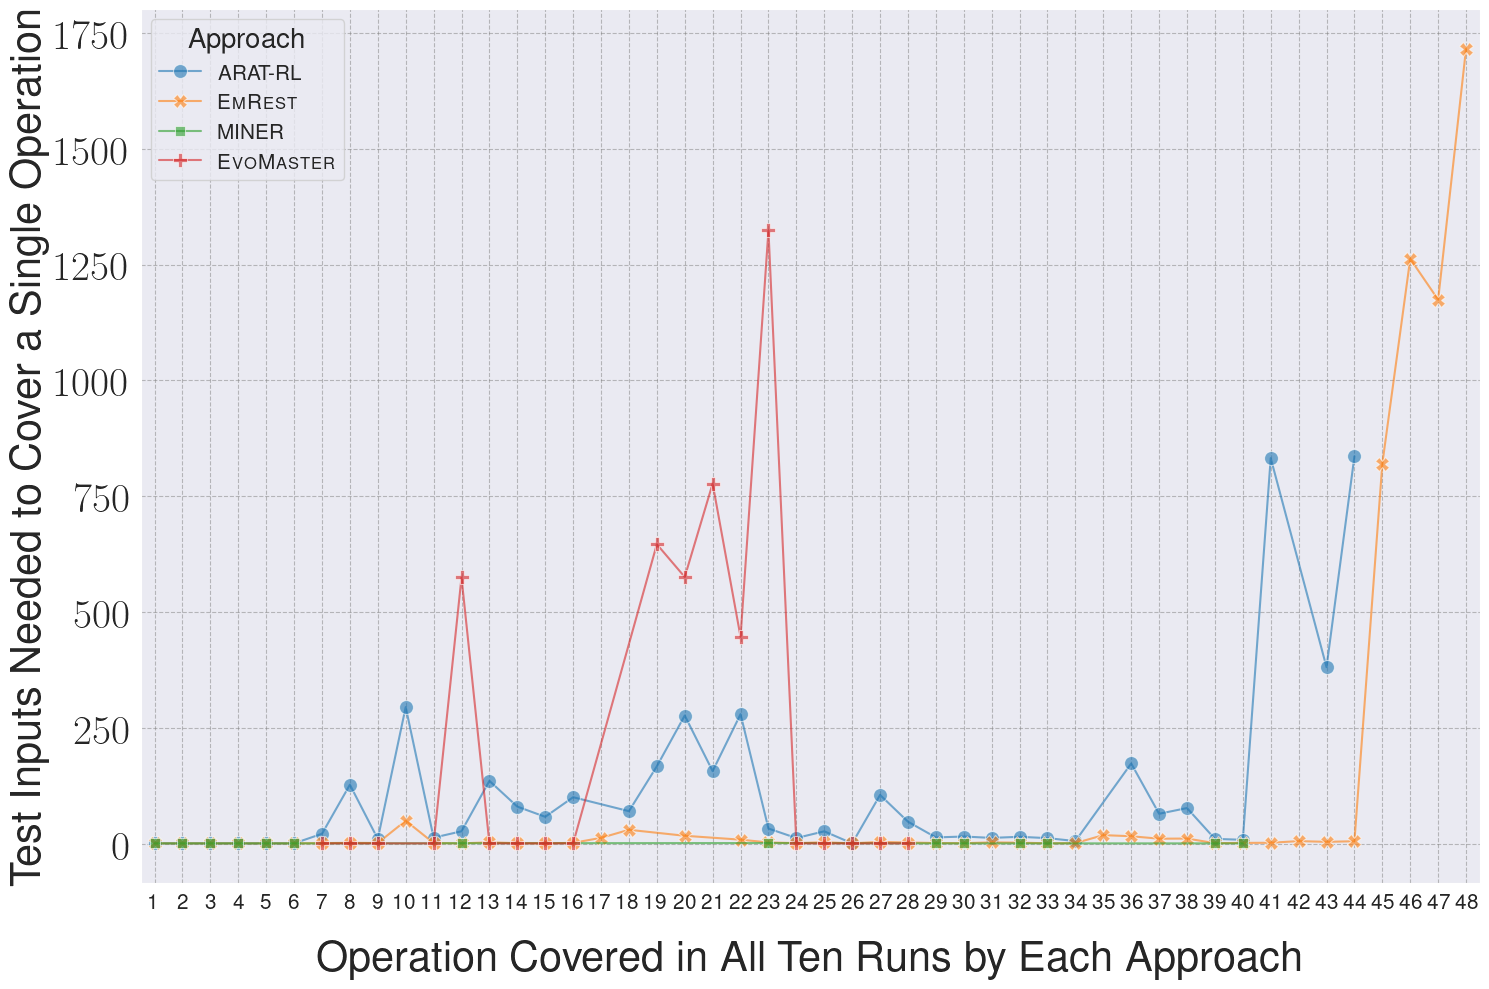

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

sut_df['plot_x'] = sut_df.apply(lambda row: f"{row['op']} (NumberOfParameters={row['num_params']})", axis=1)
sut_df['plot_y'] = sut_df['first_20X_50X']

plt.figure(figsize=(15, 10))
# 折线图  markers with big size
ax = sns.lineplot(data=sut_df, x='plot_x', y='plot_y', hue='tool', style='tool', markers=True, markersize=10, dashes=False, alpha=0.6)
# ax = sns.lineplot(data=sut_df, x='plot_x', y='plot_y', hue='tool', style='tool', markers=True, dashes=False, alpha=0.6)
# sns.scatterplot(data=sut_df, x='plot_x', y='plot_y', hue='tool', style='tool', s=100, alpha=0.8)
# set name in legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['ARAT-RL', r'\textsc{EmRest}', 'MINER', r'\textsc{EvoMaster}'], title='Approach', title_fontsize='20', fontsize='15', loc='upper left')

# plt.legend(title='Tool', title_fontsize='20', fontsize='15', loc='upper left')

# the minimum value of y-axis set to 1
# plt.ylim(1, None)

# 设置刻度字体大小
plt.yticks(fontsize=30)

# 横坐标每个op使用数字替代
plt.xticks([i for i in range(len(sut_df['plot_x'].unique()))], [i for i in range(1, len(sut_df['plot_x'].unique()) + 1)], fontsize=15)

# x, y 轴
plt.xlabel('Operation Covered in All Ten Runs by Each Approach', fontsize=30)
plt.ylabel('Test Inputs Needed to Cover a Single Operation', fontsize=30)

# x label 偏移
plt.gca().xaxis.labelpad = 20

# 调整 x 轴 两端的间距
plt.xlim(-0.5, len(sut_df['plot_x'].unique()) - 0.5)

# 去掉外围的边框
# sns.despine()

# Add a rectangular box around a specific section
# Adjust x and y limits based on the area you want to frame
# x_start = 5  # Starting x position of the box
# x_end = 10   # Ending x position of the box
# y_start = 0  # Starting y position of the box
# y_end = 500  # Ending y position of the box
# 
# # Draw a rectangle
# plt.gca().add_patch(plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, 
#                                   fill=False, edgecolor="black", linewidth=2, linestyle="-"))


# 背景 x, y 轴都要有线
plt.grid(c='gray', linestyle='--', alpha=0.5)

# 调整布局以避免重叠
plt.tight_layout()

# 显示图表
# plt.show()
plt.savefig('test_inputs_needed_to_cover_a_single_operation.pdf')

In [ ]:
# list operations that can be covered by all tools
miner_ops = sut_df[sut_df.tool == 'miner'].op.unique()
emrest_ops = sut_df[sut_df.tool == 'emrest'].op.unique()
arat_rl_ops = sut_df[sut_df.tool == 'arat-rl'].op.unique()
evo_master_ops = sut_df[sut_df.tool == 'evomaster'].op.unique()

In [29]:
# operations that can be covered by each tool
print(len(miner_ops))
print(len(emrest_ops))
print(len(arat_rl_ops))
print(len(evo_master_ops))

14
46
41
19


In [26]:

# operations that can be covered by both miner and emrest
print(len(set(miner_ops) & set(emrest_ops)))
# operations that can be covered by both arat-rl and emrest
print(len(set(emrest_ops) & set(arat_rl_ops)))
# operations that can be covered by both evo-master and emrest
print(len(set(emrest_ops) & set(evo_master_ops)))

14
39
17


In [28]:
# operations that can only be covered by emrest
print(len(set(emrest_ops) - set(miner_ops) - set(arat_rl_ops) - set(evo_master_ops)))
# operations that can only be covered by miner
print(len(set(miner_ops) - set(emrest_ops) - set(arat_rl_ops) - set(evo_master_ops)))
# operations that can only be covered by arat-rl
print(len(set(arat_rl_ops) - set(miner_ops) - set(emrest_ops) - set(evo_master_ops)))
# operations that can only be covered by evo-master
print(len(set(evo_master_ops) - set(miner_ops) - set(arat_rl_ops) - set(emrest_ops)))

7
0
0
0


In [32]:
# first_20X_50X of operations that can be covered by both miner and emrest
sut_df[(sut_df.op.isin(miner_ops)) & (sut_df.op.isin(emrest_ops)) & (sut_df.tool == "emrest")].first_20X_50X.unique()

array([1. , 3. , 1.8, 1.4, 2.5, 1.2, 1.5, 2. ])

# RQ2: Unique Bugs & Total Bugs

In [15]:
# average number of unique bugs and total bugs across ten runs
avg_bug = total_df.groupby(['SUT', 'tool']).agg(avg_total_bugs=('Total Bugs', 'mean'), avg_unique_bugs=('Unique Bugs', 'mean')).reset_index()
avg_bug.pivot(index='SUT', columns='tool', values=['avg_total_bugs', 'avg_unique_bugs']).sort_values(by=['SUT'], key=lambda x: x.map(order))

avg_total_bugs                                          \
tool                     arat-rl   emrest emrest_infer evomaster   miner   
SUT                                                                        
features-service         59303.5  19587.9        519.6  117917.9  1046.9   
genome-nexus                 0.0      0.0          0.0      27.0     0.0   
languagetool             12568.3  11657.3       1008.3    8025.5     0.0   
market                   32858.3  31911.0       1743.2   38246.4    88.3   
person-controller        62033.4  14514.4      10025.8   74402.5   200.4   
emb-project               2169.0   1570.5        897.7   37308.9    13.7   
restcountries             1008.7    504.1          5.7     486.0     0.0   
user-management          40599.3   9582.8        127.6   21830.4   438.2   
ncs                          0.0      0.0          0.0       0.0     0.0   
scs                          0.0      0.0          0.0       0.0     0.0   
gitlab-branch                0.0      0.3          0.2       0.1     0.0   
gitlab-commit                1.4     10.6          4.7       0.0     0.0   
gitlab-groups               71.2    221.3        206.9     651.3   163.3   
gitlab-issues              229.7    257.5        191.1     355.2    49.7   
gitlab-project              33.9     94.8         96.7       0.1     0.0   
gitlab-repository            0.0      0.3          0.1       0.0     0.0   

                  avg_unique_bugs                                      
tool                      arat-rl emrest emrest_infer evomaster miner  
SUT                                                                    
features-service             34.2   29.4         20.1      13.0  12.5  
genome-nexus                  0.0    0.0          0.0       0.5   0.0  
languagetool                 12.5   14.6          9.3       4.8   0.0  
market                       29.4   69.5          3.0       3.0   3.4  
person-controller           127.6  155.5         36.6      13.5  11.7  
emb-project                  15.3   14.8         14.3      15.0   2.0  
restcountries                 1.0    1.0          1.0       1.0   0.0  
user-management              18.2   28.0          9.5       6.0   6.0  
ncs                           0.0    0.0          0.0       0.0   0.0  
scs                           0.0    0.0          0.0       0.0   0.0  
gitlab-branch                 0.0    0.1          0.2       0.1   0.0  
gitlab-commit                 0.5    1.8          1.6       0.0   0.0  
gitlab-groups                 2.6    5.6          5.6       5.2   1.0  
gitlab-issues                 9.8   14.8         13.6       2.2   1.0  
gitlab-project                1.8    2.3          2.3       0.1   0.0  
gitlab-repository             0.0    0.3          0.1       0.0   0.0

In [16]:
# All unique bug_id detected across ten runs
bug_info["unique_bug_id"] = bug_info["sut"] + bug_info["bug_id"]
all_bug = bug_info.drop_duplicates(subset=['tool', 'unique_bug_id']).reset_index()
all_bug

,index,sut,tool,round,bug_id,unique_bug_id
0,0,languagetool,evomaster,1,post:/check:Error: Internal Error: Unrecognize...,languagetoolpost:/check:Error: Internal Error:...
1,1,languagetool,evomaster,1,post:/check:Error: Internal Error: Unexpected ...,languagetoolpost:/check:Error: Internal Error:...
2,2,languagetool,evomaster,1,post:/check:Error: Internal Error: Invalid num...,languagetoolpost:/check:Error: Internal Error:...
3,3,languagetool,evomaster,1,post:/check:Error: Internal Error: Unexpected ...,languagetoolpost:/check:Error: Internal Error:...
4,4,languagetool,evomaster,1,post:/check:Error: Internal Error: Unexpected ...,languagetoolpost:/check:Error: Internal Error:...
...,...,...,...,...,...,...
1012,7724,market,emrest,9,"post:/register:{""message"":""JSON parse error: C...","marketpost:/register:{""message"":""JSON parse er..."
1013,7854,person-controller,emrest,10,"post:/api/persons:message: ""Cannot deserialize...","person-controllerpost:/api/persons:message: ""C..."
1014,7894,person-controller,emrest,10,"put:/api/person:message: ""Cannot deserialize i...","person-controllerput:/api/person:message: ""Can..."
1015,7944,person-controller,emrest,10,"put:/api/persons:message: ""Cannot deserialize ...","person-controllerput:/api/persons:message: ""Ca..."


In [17]:
# All unique bug_id detected across ten runs
bug_info["unique_bug_id"] = bug_info["sut"] + bug_info["bug_id"]
all_bug = bug_info.drop_duplicates(subset=['tool', 'unique_bug_id']).reset_index()
pivoted_all_bug = all_bug.groupby(['sut', 'tool']).agg(unique_bugs=('unique_bug_id', 'nunique')).reset_index().pivot(index='sut', columns='tool', values='unique_bugs').sort_values(by=['sut'],
                                                                                                                                                                                    key=lambda x: x.map
                                                                                                                                                                                    (order)).fillna(0)
pivoted_all_bug

tool,arat-rl,emrest,emrest_infer,evomaster,miner
sut,,,,,
features-service,41.0,33.0,24.0,13.0,14.0
genome-nexus,0.0,0.0,0.0,1.0,0.0
languagetool,15.0,20.0,15.0,5.0,0.0
market,31.0,81.0,3.0,3.0,4.0
person-controller,137.0,244.0,44.0,14.0,12.0
emb-project,18.0,18.0,16.0,15.0,2.0
restcountries,1.0,1.0,1.0,1.0,0.0
user-management,25.0,30.0,11.0,6.0,6.0
gitlab-branch,0.0,1.0,1.0,1.0,0.0


# RQ2: Venn diagram - the overlap of unique bugs detected by different tools

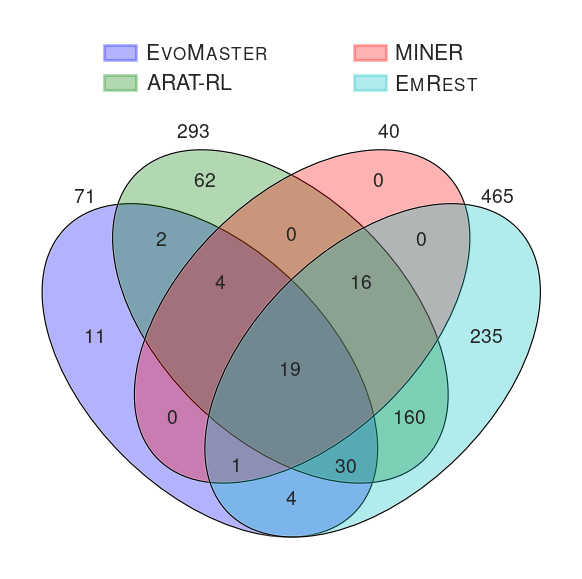

In [18]:
bug_set = dict()
tool_formal_names = {'emrest': r'\textsc{EmRest}', 'miner': r'MINER', 'evomaster': r'\textsc{EvoMaster}', 'arat-rl': 'ARAT-RL'}
for tool in all_bug.tool.unique():
    if tool == 'emrest_infer':
        continue
    bug_set[tool_formal_names[tool]] = set(all_bug[all_bug.tool == tool]["unique_bug_id"].unique())

from venny4py.venny4py import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
venny4py(bug_set)

# Calculate the increase of operation coverage of EmRest compared to other tools

In [19]:
# calculate the increase of operation coverage of EmRest compared to other tools
op_coverage_increase_df = pd.DataFrame()
for tool in total_df.tool.unique():
    if tool == 'emrest':
        continue
    op_coverage_increase_df[f"compared_to_{tool}"] = op_coverage[('op_20x_50x', 'emrest')] / op_coverage[('op_20x_50x', tool)] - 1
    # round to two decimal places
    op_coverage_increase_df[f"compared_to_{tool}"] = op_coverage_increase_df[f"compared_to_{tool}"].round(2)
op_coverage_increase_df

KeyError: ('op_20x_50x', 'emrest')

In [ ]:
op_coverage[('op_20x_50x', 'emrest')].sum() - op_coverage[('op_20x_50x', 'arat-rl')].sum()

# Calculate the increase of unique bugs detected by EmRest compared to other tools

In [ ]:
# calculate the increase of unique bugs detected by EmRest compared to other tools
bug_increase_df = pd.DataFrame()
for tool in pivoted_all_bug.columns:
    if tool == 'emrest':
        continue
    bug_increase_df[f"compared_to_{tool}"] = pivoted_all_bug['emrest'] / pivoted_all_bug[tool] - 1
    bug_increase_df[f"compared_to_{tool}"] = bug_increase_df[f"compared_to_{tool}"].round(2)
bug_increase_df.fillna(0, inplace=True)
bug_increase_df

# Calculate the decrease of first_20X_50X of EmRest compared to other tools

In [ ]:
avg_first_20x_50x_decrease_df = pd.DataFrame()
for tool in avg_first_20x_50x.columns:
    if tool == ('first_20X_50X', 'emrest'):
        continue
    if tool == ('first_20X_50X', 'emrest_infer') or tool == ('first_20X_50X', 'miner'):
        continue
    avg_first_20x_50x_decrease_df[f"compared_to_{tool[1]}"] = avg_first_20x_50x[('first_20X_50X', 'emrest')] / avg_first_20x_50x[tool]
    avg_first_20x_50x_decrease_df[f"compared_to_{tool[1]}"] = avg_first_20x_50x_decrease_df[f"compared_to_{tool[1]}"].round(2)
avg_first_20x_50x_decrease_df.fillna(0)

In [ ]:
# find the minimum value of the decrease of each row in first_20X_50X
avg_first_20x_50x_decrease_df.max(axis=1)

 # A_12 and p-value

In [ ]:
from scipy import stats


def p_value(a, b):
    """
    Compute the p-value of Mann-Whitney U test.
    """
    return stats.mannwhitneyu(a, b, alternative='two-sided')[1]


def wilcoxon_p_value(a, b):
    """
    Compute the p-value of Wilcoxon signed-rank test.
    """
    return stats.wilcoxon(a, b, alternative='greater')[1]


def a12(a, b):
    """
    Computer the Vargha and Delaney’s Aˆ12 statistics.
    """
    arr = np.append(a, b)
    # the rank sum of a
    r1 = np.sum(stats.rankdata(arr)[:len(a)])
    return (r1 / len(a) - (len(a) + 1) / 2) / len(b)

In [ ]:
# calculate the A12 of operation coverage
a12_df = pd.DataFrame()
for sut in total_df.SUT.unique():
    for tool in total_df.tool.unique():
        if tool == 'emrest':
            continue
        a12_df.loc[sut, tool] = a12(total_df[(total_df.SUT == sut) & (total_df.tool == 'emrest')]['Op_20X_50X'], total_df[(total_df.SUT == sut) & (total_df.tool == tool)]['Op_20X_50X'])
a12_df.index.name = 'SUT'
a12_df.sort_values(by=['SUT'], key=lambda x: x.map(order)).round(3)

In [ ]:
# calculate the p-value of operation coverage

p_value_df = pd.DataFrame()
for sut in total_df.SUT.unique():
    for tool in total_df.tool.unique():
        if tool == 'emrest':
            continue
        p_value_df.loc[sut, tool] = p_value(total_df[(total_df.SUT == sut) & (total_df.tool == 'emrest')]['Op_20X_50X'], total_df[(total_df.SUT == sut) & (total_df.tool == tool)]['Op_20X_50X'])
p_value_df.index.name = 'SUT'
# 保留两位小数
p_value_df = p_value_df.round(2)
p_value_df.sort_values(by=['SUT'], key=lambda x: x.map(order))

In [ ]:
a12_p_value_df = pd.concat([a12_df, p_value_df], axis=1, keys=['A12', 'p-value'])
a12_p_value_df

In [ ]:
# Wilcoxon signed-rank test
# for operation_coverage
from scipy.stats import wilcoxon

t_vsEmRestInfer, p_vsEmRestInfer = wilcoxon(op_coverage[('op_20x_50x', 'emrest')], op_coverage[('op_20x_50x', 'emrest_infer')], alternative='greater')
t_vsARAT_RL, p_vsARAT_RL = wilcoxon(op_coverage[('op_20x_50x', 'emrest')], op_coverage[('op_20x_50x', 'arat-rl')], alternative='greater')
t_vsEvoMaster, p_vsEvoMaster = wilcoxon(op_coverage[('op_20x_50x', 'emrest')], op_coverage[('op_20x_50x', 'evomaster')], alternative='greater')
t_vsMINER, p_vsMINER = wilcoxon(op_coverage[('op_20x_50x', 'emrest')], op_coverage[('op_20x_50x', 'miner')], alternative='greater')

print("Wilcoxon signed-rank test for operation coverage:")
print(f"    EmRest vs EmRestInfer: p={p_vsEmRestInfer:.3f}")
print(f"    EmRest vs ARAT-RL: p={p_vsARAT_RL:.3f}")
print(f"    EmRest vs EvoMaster: p={p_vsEvoMaster:.3f}")
print(f"    EmRest vs MINER: p={p_vsMINER:.3f}")

# for first_20X
t_vsEmRestInfer, p_vsEmRestInfer = wilcoxon(avg_first_20x_50x[('first_20X_50X', 'emrest')], avg_first_20x_50x[('first_20X_50X', 'emrest_infer')], alternative='less')
t_vsARAT_RL, p_vsARAT_RL = wilcoxon(avg_first_20x_50x[('first_20X_50X', 'emrest')], avg_first_20x_50x[('first_20X_50X', 'arat-rl')], alternative='less')
t_vsEvoMaster, p_vsEvoMaster = wilcoxon(avg_first_20x_50x[('first_20X_50X', 'emrest')], avg_first_20x_50x[('first_20X_50X', 'evomaster')], alternative='less')
t_vsMINER, p_vsMINER = wilcoxon(avg_first_20x_50x[('first_20X_50X', 'emrest')], avg_first_20x_50x[('first_20X_50X', 'miner')], alternative='less')

print("Wilcoxon signed-rank test for first_20X_50X:")
print(f"    EmRest vs EmRestInfer: p={p_vsEmRestInfer:.3f}")
print(f"    EmRest vs ARAT-RL: p={p_vsARAT_RL:.3f}")
print(f"    EmRest vs EvoMaster: p={p_vsEvoMaster:.3f}")
print(f"    EmRest vs MINER: p={p_vsMINER:.3f}")

# for unique_bugs
t_vsEmRestInfer, p_vsEmRestInfer = wilcoxon(pivoted_all_bug['emrest'], pivoted_all_bug['emrest_infer'], alternative='greater')
t_vsARAT_RL, p_vsARAT_RL = wilcoxon(pivoted_all_bug['emrest'], pivoted_all_bug['arat-rl'], alternative='greater')
t_vsEvoMaster, p_vsEvoMaster = wilcoxon(pivoted_all_bug['emrest'], pivoted_all_bug['evomaster'], alternative='greater')
t_vsMINER, p_vsMINER = wilcoxon(pivoted_all_bug['emrest'], pivoted_all_bug['miner'], alternative='greater')

print("Wilcoxon signed-rank test for unique bugs:")
print(f"    EmRest vs EmRestInfer: p={p_vsEmRestInfer:.3f}")
print(f"    EmRest vs ARAT-RL: p={p_vsARAT_RL:.3f}")
print(f"    EmRest vs EvoMaster: p={p_vsEvoMaster:.3f}")
print(f"    EmRest vs MINER: p={p_vsMINER:.3f}")
